# 1주차
- Predicting Insurance Premium
- 의료보험 데이터를 활용해서 보험료를 예측하는 회귀문제

## 데이터 이해
- charges: 보험료, 종속변수
- age: 나이
- gender: 성별
- bmi: body mass index, 체질량 지수
- children: 자녀 수
- smoker: 흡연 여부
- region: 거주 지역
- medical_history: 질병 이력
- family_medical_history: 가족 질병 이력
- exercise_frequency: 운동 빈도
- occupation: 직업 종류
- coverage_level: 보험 종류


In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
from datetime import datetime

# preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer

# validation
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score

# valuation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# modeling
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# etc 
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 불러오기
data = pd.read_csv("C:/Users/sssum/Downloads/insurance_dataset.csv/insurance_dataset.csv")
data.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,None,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,None,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,None,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


In [3]:
# 데이터 기본 정보 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   age                     1000000 non-null  int64  
 1   gender                  1000000 non-null  object 
 2   bmi                     1000000 non-null  float64
 3   children                1000000 non-null  int64  
 4   smoker                  1000000 non-null  object 
 5   region                  1000000 non-null  object 
 6   medical_history         1000000 non-null  object 
 7   family_medical_history  1000000 non-null  object 
 8   exercise_frequency      1000000 non-null  object 
 9   occupation              1000000 non-null  object 
 10  coverage_level          1000000 non-null  object 
 11  charges                 1000000 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 91.6+ MB


In [4]:
# 데이터 통계정보 확인
data.describe()

,age,bmi,children,charges
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,41.495282,34.001839,2.499886,16735.117481
std,13.855189,9.231680,1.707679,4415.808211
min,18.000000,18.000000,0.000000,3445.011643
25%,29.000000,26.020000,1.000000,13600.372379
50%,41.000000,34.000000,2.000000,16622.127973
75%,53.000000,41.990000,4.000000,19781.465410
max,65.000000,50.000000,5.000000,32561.560374


- 평균과 표준편차가 거의 비슷한 컬럼은 분포가 퍼져있을 확률이 높으므로 후에 분포를 모아주는 작업이 필요할 수 있음
- 값 범위가 크게 다른 속성이 있으면 스케일링 작업이 필요함, 종속변수는 제외

## EDA

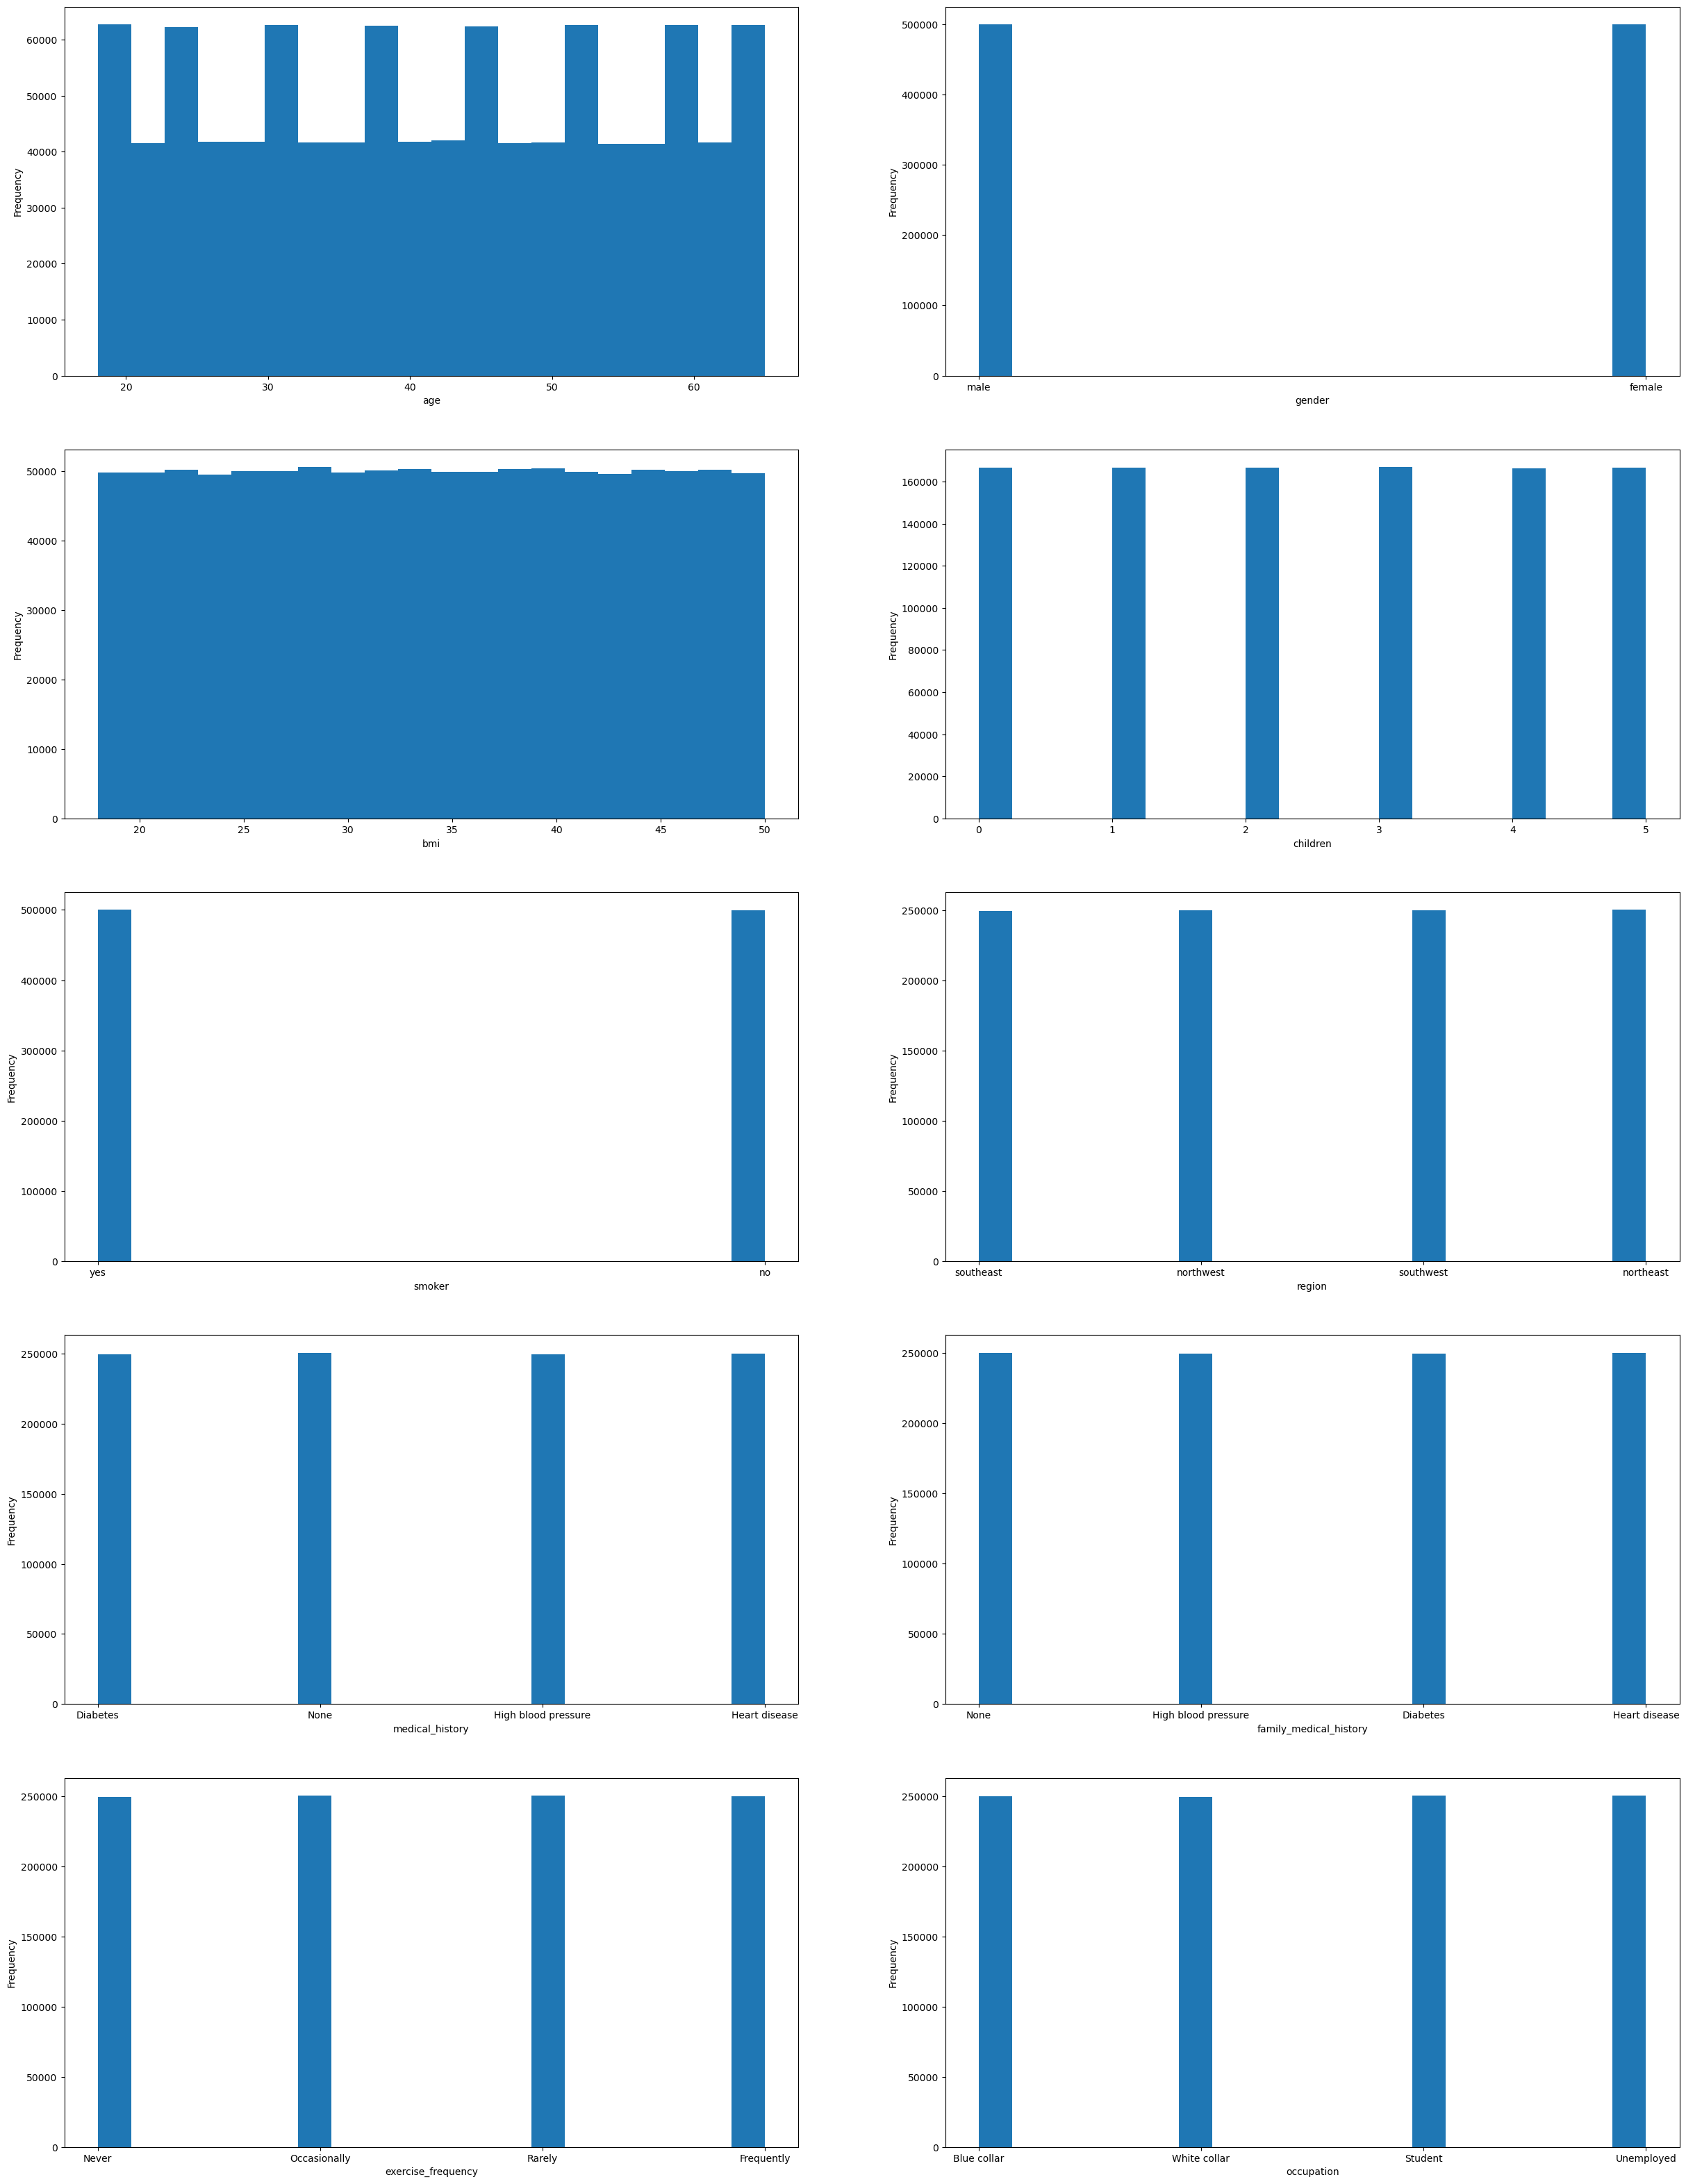

In [5]:
# 속성 분포 확인
fig, ax = plt.subplots(5, 2, figsize=(30, 40))

idx = 0
for i in range(5): # subplot 행
    for j in range(2): # subplot 열
        colname = list(data.columns)[idx]
        ax[i][j].hist(data[colname], bins=20)
        ax[i][j].set_xlabel(colname)
        ax[i][j].set_ylabel('Frequency')
        
        idx += 1

컬럼들의 값 분포를 보았을 때, 크게 치우친 부분 없이 고르게 분포되어 있음을 알 수 있음.

In [6]:
# 컬럼 간 상관관계 파악
data.corr()

,age,bmi,children,charges
age,1.000000,0.001428,-0.001317,0.063390
bmi,0.001428,1.000000,-0.001635,0.104429
children,-0.001317,-0.001635,1.000000,0.076801
charges,0.063390,0.104429,0.076801,1.000000


In [8]:
# 연령별 구간 설정
bins = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, np.inf]
age_bin = pd.cut(data['age'], bins=bins, labels=[i+1 for i in range(len(bins)-1)])
data['age_bin'] = age_bin
data.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges,age_bin
0,46,male,21.45,5,yes,southeast,Diabetes,None,Never,Blue collar,Premium,20460.307669,7
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218,2
2,38,male,44.88,2,yes,southwest,None,High blood pressure,Occasionally,Blue collar,Premium,20204.476302,5
3,25,male,19.89,0,no,northwest,None,Diabetes,Rarely,White collar,Standard,11789.029843,2
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838,7


In [9]:
# 구간화 속성 분포 확인
data['age_bin'].value_counts()

3     104522
10    104286
5     104221
6     104189
4     104138
7     104067
8     104041
9     103994
2     103797
1      62745
Name: age_bin, dtype: int64

구간화 작업
- 참고한 예시에서 age 속성의 분포를 확인했을 때, 18-19세만 다른 나이대들의 2배였음.
- 그래서 다른 나이대들은 5세로 분포를 넓히고, 18-19세는 분포를 좁혀 구간화를 진행함.
- 이를 통해 위 결과처럼 다른 나이대분포가 더 많아졌음을 알 수 있음.
- 구간화 작업은 불균형이 있는 속성의 분포를 조절하는 방식
- 우리가 사용한 데이터는 나이대에 불균형이 없어서 진행하지 않아도 됨

<Axes: ylabel='bmi'>

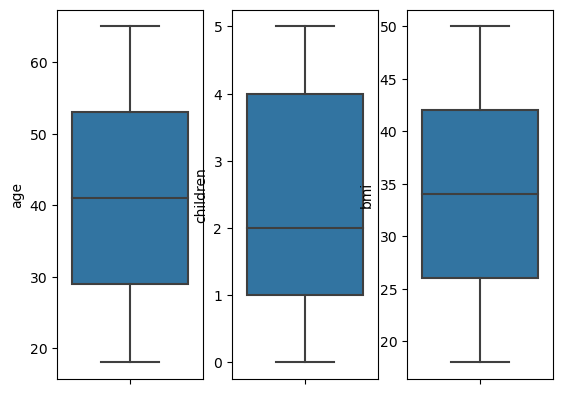

In [8]:
# 이상치 탐지
plt.subplot(1, 3, 1)
sns.boxplot(data=data, y='age')
plt.subplot(1, 3, 2)
sns.boxplot(data=data, y='children')
plt.subplot(1, 3, 3)
sns.boxplot(data=data, y='bmi')

이상치도 없음.

In [9]:
# 해당 문제는 이상치가 없지만, 이상치를 확인하는 방법 코드
# IQR: Inter Quantile Range, 사분위수 25%, 75% 사이인 
# Interquatile Range 범위에서 1.5를 곱해 각각 25% 사분위수와 
# 75% 사분위수를 더한 범위를 벗어난 값을 이상치로 보고 삭제하는 방식 
bmi_q1 = data['bmi'].quantile(q=0.25)
bmi_q3 = data['bmi'].quantile(q=0.75)
iqr = bmi_q3 - bmi_q1

condi1 = (data['bmi'] < (bmi_q1 - (1.5 * iqr)))
condi2 = (data['bmi'] > (bmi_q3 + (1.5 * iqr)))
outliers = data[condi1 | condi2]
outliers['bmi']

Series([], Name: bmi, dtype: float64)

## 데이터 전처리
- 정규화: 변수 범위를 0~1 사이로 옮기는 작업, MinMaxScaler
- 표준화: 변수 범위 평균 0, 표준편차 1로 변환, StandardScaler

정규변환 (정규분포에 가깝게 변수를 변환)
- 필요한 경우: 정규성 분포를 따른다는 가정하에 모델링 해야하는 선형회귀, 가우시안 나이브 베이즈 모델을 사용하는 경우
- 로그변환: 변수에 로그를 취해주면 정규분포의 형태와 가깝게 변환됨
- Power Transformation: 특정 수식에 따른 변수 변환
- Quantile Transformation: 미리 정한 분포에 따라 그에 상승하는 x값 반환

In [5]:
# 결측치 처리
# family_medical_history, medical_history 컬럼에 None으로 결측치 존재
# 결측치 비율이 25%
print(data['family_medical_history'].value_counts())
print(data['medical_history'].value_counts())

None                   250404
Heart disease          250035
High blood pressure    249824
Diabetes               249737
Name: family_medical_history, dtype: int64
None                   250762
Heart disease          250121
High blood pressure    249782
Diabetes               249335
Name: medical_history, dtype: int64


In [6]:
# 결측치가 있는 컬럼의 다른 컬럼과의 관계 파악 - 나이
family_filter = data[data['family_medical_history'] == 'None']['age']
medical_filter = data[data['medical_history'] == 'None']['age']
print(family_filter.describe())
print(medical_filter.describe())

count    250404.000000
mean         41.500851
std          13.855506
min          18.000000
25%          29.000000
50%          42.000000
75%          53.000000
max          65.000000
Name: age, dtype: float64
count    250762.000000
mean         41.485863
std          13.845353
min          18.000000
25%          30.000000
50%          41.000000
75%          53.000000
max          65.000000
Name: age, dtype: float64


In [7]:
# 결측치가 있는 컬럼의 다른 컬럼과의 관계 파악 - bmi
family_filter = data[data['family_medical_history'] == 'None']['bmi']
medical_filter = data[data['medical_history'] == 'None']['bmi']
print(family_filter.describe())
print(medical_filter.describe())

count    250404.000000
mean         34.010019
std           9.221582
min          18.000000
25%          26.030000
50%          34.010000
75%          41.950000
max          50.000000
Name: bmi, dtype: float64
count    250762.000000
mean         34.018554
std           9.229882
min          18.000000
25%          26.040000
50%          34.050000
75%          41.990000
max          50.000000
Name: bmi, dtype: float64


In [8]:
# 결측치가 있는 컬럼의 다른 컬럼과의 관계 파악 - children
family_filter = data[data['family_medical_history'] == 'None']['children']
medical_filter = data[data['medical_history'] == 'None']['children']
print(family_filter.describe())
print(medical_filter.describe())

count    250404.000000
mean          2.499493
std           1.705744
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           5.000000
Name: children, dtype: float64
count    250762.000000
mean          2.502118
std           1.708984
min           0.000000
25%           1.000000
50%           3.000000
75%           4.000000
max           5.000000
Name: children, dtype: float64


결측치 행의 나이, bmi, 자녀 수 컬럼 값들은 고르게 분포되어있음.

In [9]:
# 결측치 행 데이터의 범주형 컬럼 값 분포 확인
None_data = data[(data['family_medical_history'] == 'None') & (data['medical_history'] == 'None')]
None_data.describe(include='object')

,gender,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level
count,62838,62838,62838,62838,62838,62838,62838,62838
unique,2,2,4,1,1,4,4,3
top,female,yes,southwest,None,None,Rarely,Unemployed,Basic
freq,31536,31716,15899,62838,62838,15862,15813,21017


범주형 컬럼도 분포가 고르다고 판단함. 결측치는 None으로 저장하고 분석 진행함.

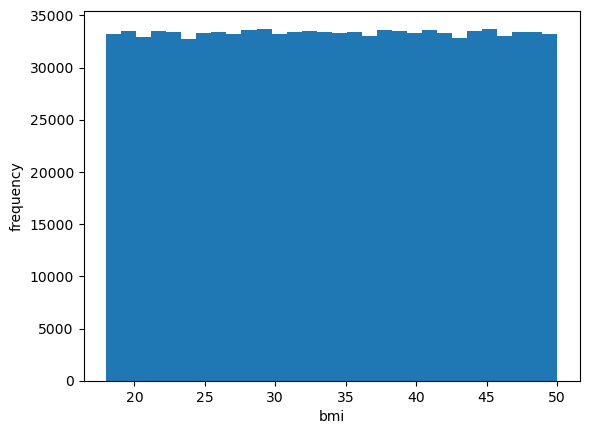

In [10]:
# 정규분포 확인
plt.figsize = (10, 10)
plt.hist(data['bmi'], bins=30)
plt.xlabel('bmi')
plt.ylabel('frequency')
plt.show()

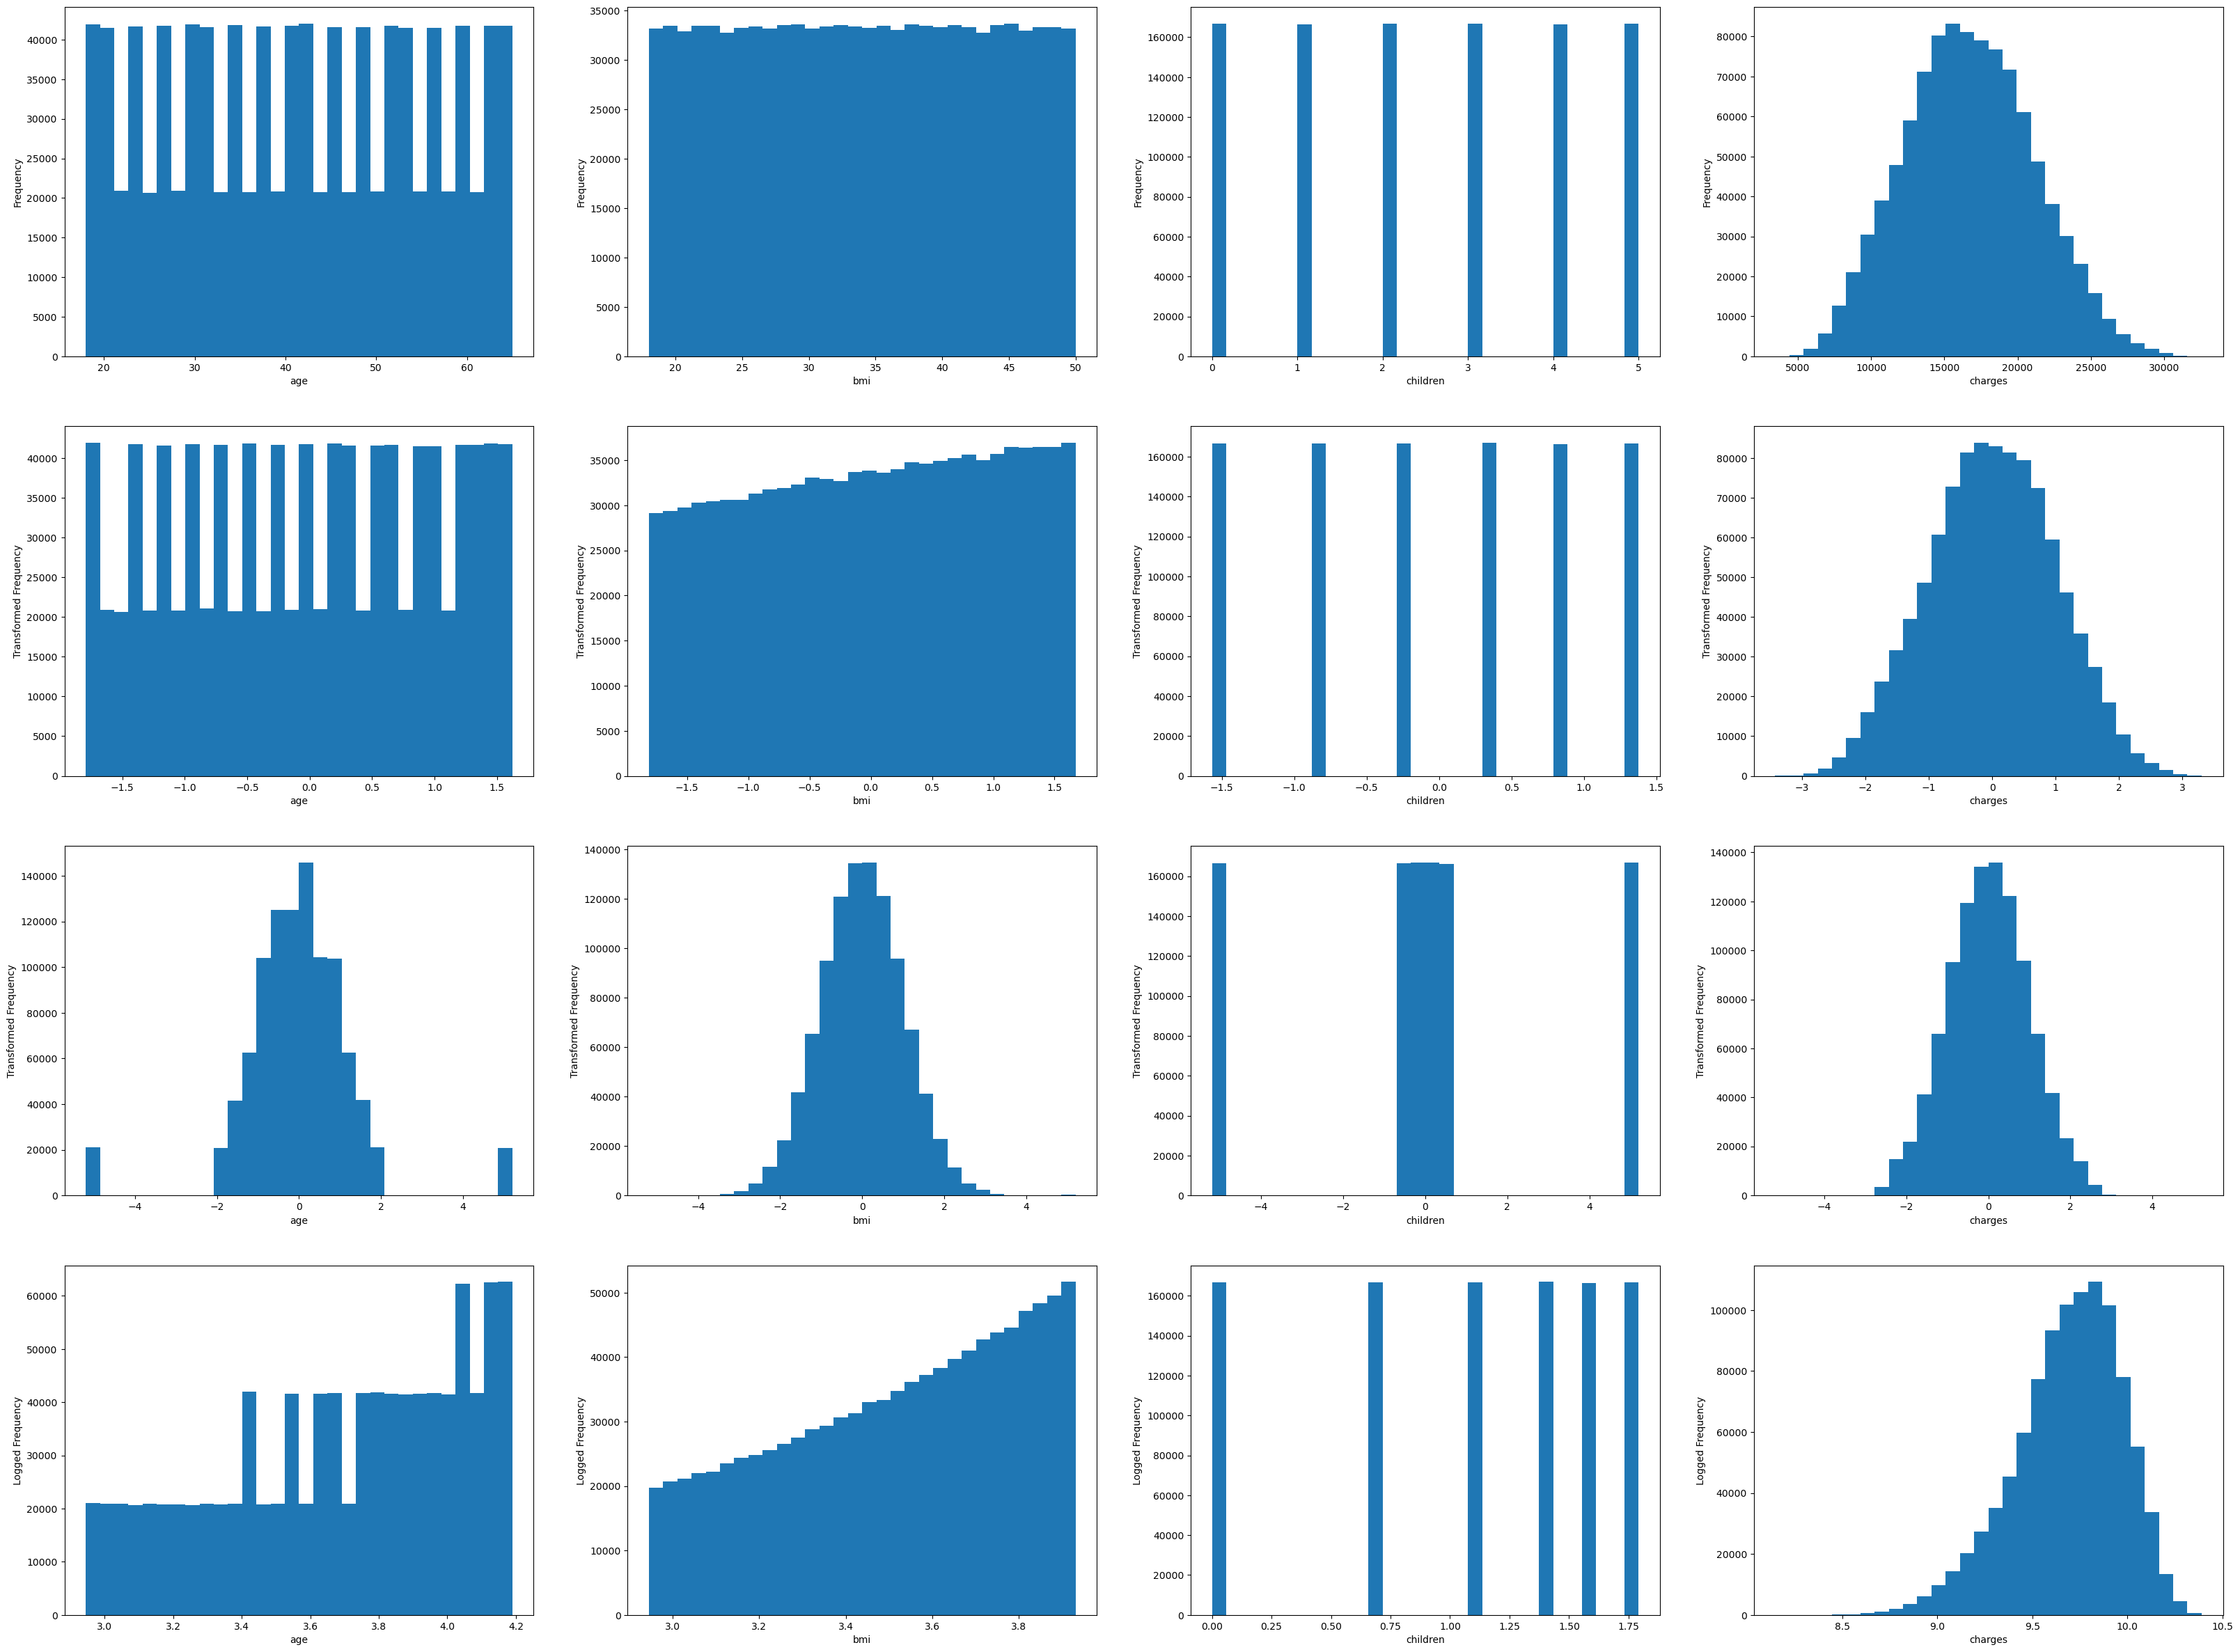

In [11]:
# 로그 변환
to_scale = ['age', 'bmi', 'children', 'charges']
df_to_scale = data[to_scale].copy()

quantile = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution='normal')
power = PowerTransformer(method='yeo-johnson')
q_scaled = quantile.fit_transform(df_to_scale)
yj = power.fit_transform(df_to_scale)

q_scaled_df = pd.DataFrame(q_scaled, columns=to_scale)
scaled_df = pd.DataFrame(yj, columns=to_scale)
logged_df = pd.DataFrame(np.log1p(df_to_scale), columns=to_scale)
# 로그 특성상 0보다 작은 값이 있는 속성에는 사용 불가

fig, ax = plt.subplots(4, 4, figsize=(40, 30))

for i in range(4):
    idx=0
    for j in range(4):
        colname = to_scale[idx]
        if i == 0:
            ax[i][j].hist(df_to_scale[colname], bins=30)
            ax[i][j].set_xlabel(colname)
            ax[i][j].set_ylabel('Frequency')
            
        elif i == 1:
            ax[i][j].hist(scaled_df[colname], bins=30)
            ax[i][j].set_xlabel(colname)
            ax[i][j].set_ylabel('Transformed Frequency')  
        elif i == 2:
            ax[i][j].hist(q_scaled_df[colname], bins=30)
            ax[i][j].set_xlabel(colname)
            ax[i][j].set_ylabel('Transformed Frequency')
        elif i == 3:
            ax[i][j].hist(logged_df[colname], bins=30)
            ax[i][j].set_xlabel(colname)
            ax[i][j].set_ylabel('Logged Frequency')
            
        idx +=1

In [12]:
# 데이터 분할
x = data.drop(['charges'], axis=1)
y = data['charges']

train_input, test_input, train_target, test_target = train_test_split(x, y, test_size=0.2, shuffle=True)

In [13]:
# Quantile Transformer 사용
to_scale = ['age', 'bmi']

quantile = QuantileTransformer(n_quantiles=10, random_state=42, output_distribution='normal')

for col in to_scale:
    quantile.fit(train_input[[col]]) # 2차원 데이터로 투입하기 위해 괄호 두 개 사용
    train_input[col] = quantile.transform(train_input[[col]]).flatten()
    test_input[col] = quantile.transform(test_input[[col]]).flatten()

In [14]:
# 결과 확인
print(train_input.head())
print('-----------------')
print(test_input.head())

             age  gender       bmi  children smoker     region  \
918171  0.234219  female  0.199243         4    yes  southwest   
975088  0.139710  female -0.065929         4     no  northeast   
208059  1.012893    male  0.758401         4    yes  northeast   
254238  0.027855    male  1.126909         1    yes  southwest   
732281 -1.012893    male -0.905560         3     no  southwest   

            medical_history family_medical_history exercise_frequency  \
918171        Heart disease                   None              Never   
975088        Heart disease               Diabetes       Occasionally   
208059  High blood pressure                   None             Rarely   
254238  High blood pressure          Heart disease       Occasionally   
732281        Heart disease               Diabetes             Rarely   

         occupation coverage_level  
918171  Blue collar       Standard  
975088      Student        Premium  
208059   Unemployed        Premium  
254238  Blue col

In [15]:
# 표준화 진행
cols = ['age', 'bmi', 'children']
for col in cols:
    std = StandardScaler()
    std.fit(train_input[[col]])
    train_input[col] = std.transform(train_input[[col]]).flatten()
    test_input[col] = std.transform(test_input[[col]]).flatten()
    
train_input.describe()

,age,bmi,children
count,8.000000e+05,8.000000e+05,8.000000e+05
mean,7.878143e-18,1.765699e-17,-7.061907e-17
std,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.745486e+00,-5.184883e+00,-1.464110e+00
25%,-4.604557e-01,-6.733044e-01,-8.785505e-01
50%,2.539500e-02,-1.536747e-03,2.925691e-01
75%,4.546773e-01,6.728979e-01,8.781289e-01
max,3.756087e+00,5.181024e+00,1.463689e+00


In [16]:
# 범주형 변수 처리 - gender
onehot_gender = OneHotEncoder()
gender_train = train_input[['gender']]
gender_test = test_input[['gender']]

onehot_gender.fit(gender_train)
gender_train_onehot_gender = onehot_gender.transform(gender_train).toarray()
gender_test_onehot_gender = onehot_gender.transform(gender_test).toarray()

train_input['gender'] = gender_train_onehot_gender[:, 1].astype(np.uint8)
test_input['gender'] = gender_test_onehot_gender[:, 1].astype(np.uint8)

train_input.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level
918171,0.174266,0,0.196685,0.878129,yes,southwest,Heart disease,None,Never,Blue collar,Standard
975088,0.106087,0,-0.067651,0.878129,no,northeast,Heart disease,Diabetes,Occasionally,Student,Premium
208059,0.735999,1,0.754081,0.878129,yes,northeast,High blood pressure,None,Rarely,Unemployed,Premium
254238,0.025395,1,1.121428,-0.878550,yes,southwest,High blood pressure,Heart disease,Occasionally,Blue collar,Standard
732281,-0.725398,1,-0.904637,0.292569,no,southwest,Heart disease,Diabetes,Rarely,Blue collar,Standard


In [17]:
# 범주형 변수 처리 - smoker
onehot_smoker = OneHotEncoder()
smoker_train = train_input[['smoker']]
smoker_test = test_input[['smoker']]

onehot_smoker.fit(smoker_train)
smoker_train_onehot = onehot_smoker.transform(smoker_train).toarray()
smoker_test_onehot = onehot_smoker.transform(smoker_test).toarray()

train_input['smoker'] = smoker_train_onehot[:, 1].astype(np.uint8)
test_input['smoker'] = smoker_test_onehot[:, 1].astype(np.uint8)

train_input.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level
918171,0.174266,0,0.196685,0.878129,1,southwest,Heart disease,None,Never,Blue collar,Standard
975088,0.106087,0,-0.067651,0.878129,0,northeast,Heart disease,Diabetes,Occasionally,Student,Premium
208059,0.735999,1,0.754081,0.878129,1,northeast,High blood pressure,None,Rarely,Unemployed,Premium
254238,0.025395,1,1.121428,-0.878550,1,southwest,High blood pressure,Heart disease,Occasionally,Blue collar,Standard
732281,-0.725398,1,-0.904637,0.292569,0,southwest,Heart disease,Diabetes,Rarely,Blue collar,Standard


In [18]:
# 먼저 라벨 인코더를 사용하여 거주지역을 숫자형으로 바꾸기
label_region = LabelEncoder()
label_region.fit(train_input['region'])

train_input['region'] = label_region.transform(train_input['region'])
test_input['region'] = label_region.transform(test_input['region'])

train_input.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level
918171,0.174266,0,0.196685,0.878129,1,3,Heart disease,None,Never,Blue collar,Standard
975088,0.106087,0,-0.067651,0.878129,0,0,Heart disease,Diabetes,Occasionally,Student,Premium
208059,0.735999,1,0.754081,0.878129,1,0,High blood pressure,None,Rarely,Unemployed,Premium
254238,0.025395,1,1.121428,-0.878550,1,3,High blood pressure,Heart disease,Occasionally,Blue collar,Standard
732281,-0.725398,1,-0.904637,0.292569,0,3,Heart disease,Diabetes,Rarely,Blue collar,Standard


In [19]:
# one-hot encoding으로 거주지역 바꾸기
onehot_region = OneHotEncoder()
region_train = train_input[['region']]
region_test = test_input[['region']]

onehot_region.fit(region_train)
region_train_onehot = onehot_region.transform(region_train).toarray()
region_test_onehot = onehot_region.transform(region_test).toarray()

train_input['region_1'] = region_train_onehot[:, 1].astype(np.uint8)
train_input['region_2'] = region_train_onehot[:, 2].astype(np.uint8)
train_input['region_3'] = region_train_onehot[:, 3].astype(np.uint8)


test_input['region_1'] = region_test_onehot[:, 1].astype(np.uint8)
test_input['region_2'] = region_test_onehot[:, 2].astype(np.uint8)
test_input['region_3'] = region_test_onehot[:, 3].astype(np.uint8)

train_input.drop(['region'], axis=1, inplace=True)
test_input.drop(['region'], axis=1, inplace=True)

In [20]:
# 결과 확인
train_input.head()

,age,gender,bmi,children,smoker,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,region_1,region_2,region_3
918171,0.174266,0,0.196685,0.878129,1,Heart disease,None,Never,Blue collar,Standard,0,0,1
975088,0.106087,0,-0.067651,0.878129,0,Heart disease,Diabetes,Occasionally,Student,Premium,0,0,0
208059,0.735999,1,0.754081,0.878129,1,High blood pressure,None,Rarely,Unemployed,Premium,0,0,0
254238,0.025395,1,1.121428,-0.878550,1,High blood pressure,Heart disease,Occasionally,Blue collar,Standard,0,0,1
732281,-0.725398,1,-0.904637,0.292569,0,Heart disease,Diabetes,Rarely,Blue collar,Standard,0,0,1


In [21]:
# 그 외 범주형 변수 모두 변형
# medical_history
label_medical = LabelEncoder()
label_medical.fit(train_input['medical_history'])

train_input['medical_history'] = label_medical.transform(train_input['medical_history'])
test_input['medical_history'] = label_medical.transform(test_input['medical_history'])

train_input.head()

onehot_medical = OneHotEncoder()
medical_train = train_input[['medical_history']]
medical_test = test_input[['medical_history']]

onehot_medical.fit(medical_train)
medical_train_onehot = onehot_medical.transform(medical_train).toarray()
medical_test_onehot = onehot_medical.transform(medical_test).toarray()

train_input['medical_1'] = medical_train_onehot[:, 1].astype(np.uint8)
train_input['medical_2'] = medical_train_onehot[:, 2].astype(np.uint8)
train_input['medical_3'] = medical_train_onehot[:, 3].astype(np.uint8)


test_input['medical_1'] = medical_test_onehot[:, 1].astype(np.uint8)
test_input['medical_2'] = medical_test_onehot[:, 2].astype(np.uint8)
test_input['medical_3'] = medical_test_onehot[:, 3].astype(np.uint8)

train_input.drop(['medical_history'], axis=1, inplace=True)
test_input.drop(['medical_history'], axis=1, inplace=True)

In [22]:
# 그 외 범주형 변수 모두 변형
# family_medical_history
label_family = LabelEncoder()
label_family.fit(train_input['family_medical_history'])

train_input['family_medical_history'] = label_family.transform(train_input['family_medical_history'])
test_input['family_medical_history'] = label_family.transform(test_input['family_medical_history'])

train_input.head()

onehot_family = OneHotEncoder()
family_train = train_input[['family_medical_history']]
family_test = test_input[['family_medical_history']]

onehot_family.fit(family_train)
family_train_onehot = onehot_family.transform(family_train).toarray()
family_test_onehot = onehot_family.transform(family_test).toarray()

train_input['family_1'] = family_train_onehot[:, 1].astype(np.uint8)
train_input['family_2'] = family_train_onehot[:, 2].astype(np.uint8)
train_input['family_3'] = family_train_onehot[:, 3].astype(np.uint8)


test_input['family_1'] = family_test_onehot[:, 1].astype(np.uint8)
test_input['family_2'] = family_test_onehot[:, 2].astype(np.uint8)
test_input['family_3'] = family_test_onehot[:, 3].astype(np.uint8)

train_input.drop(['family_medical_history'], axis=1, inplace=True)
test_input.drop(['family_medical_history'], axis=1, inplace=True)

In [23]:
# 그 외 범주형 변수 모두 변형
# exercise_frequency
label_exercise = LabelEncoder()
label_exercise.fit(train_input['exercise_frequency'])

train_input['exercise_frequency'] = label_exercise.transform(train_input['exercise_frequency'])
test_input['exercise_frequency'] = label_exercise.transform(test_input['exercise_frequency'])

train_input.head()

onehot_exercise = OneHotEncoder()
exercise_train = train_input[['exercise_frequency']]
exercise_test = test_input[['exercise_frequency']]

onehot_exercise.fit(exercise_train)
exercise_train_onehot = onehot_exercise.transform(exercise_train).toarray()
exercise_test_onehot = onehot_exercise.transform(exercise_test).toarray()

train_input['exercise_1'] = exercise_train_onehot[:, 1].astype(np.uint8)
train_input['exercise_2'] = exercise_train_onehot[:, 2].astype(np.uint8)
train_input['exercise_3'] = exercise_train_onehot[:, 3].astype(np.uint8)


test_input['exercise_1'] = exercise_test_onehot[:, 1].astype(np.uint8)
test_input['exercise_2'] = exercise_test_onehot[:, 2].astype(np.uint8)
test_input['exercise_3'] = exercise_test_onehot[:, 3].astype(np.uint8)

train_input.drop(['exercise_frequency'], axis=1, inplace=True)
test_input.drop(['exercise_frequency'], axis=1, inplace=True)

In [24]:
train_input.head()

,age,gender,bmi,children,smoker,occupation,coverage_level,region_1,region_2,region_3,medical_1,medical_2,medical_3,family_1,family_2,family_3,exercise_1,exercise_2,exercise_3
918171,0.174266,0,0.196685,0.878129,1,Blue collar,Standard,0,0,1,1,0,0,0,0,1,1,0,0
975088,0.106087,0,-0.067651,0.878129,0,Student,Premium,0,0,0,1,0,0,0,0,0,0,1,0
208059,0.735999,1,0.754081,0.878129,1,Unemployed,Premium,0,0,0,0,1,0,0,0,1,0,0,1
254238,0.025395,1,1.121428,-0.878550,1,Blue collar,Standard,0,0,1,0,1,0,1,0,0,0,1,0
732281,-0.725398,1,-0.904637,0.292569,0,Blue collar,Standard,0,0,1,1,0,0,0,0,0,0,0,1


In [25]:
# 그 외 범주형 변수 모두 변형
# occupation
label_occupation = LabelEncoder()
label_occupation.fit(train_input['occupation'])

train_input['occupation'] = label_occupation.transform(train_input['occupation'])
test_input['occupation'] = label_occupation.transform(test_input['occupation'])

train_input.head()

onehot_occupation = OneHotEncoder()
occupation_train = train_input[['occupation']]
occupation_test = test_input[['occupation']]

onehot_occupation.fit(occupation_train)
occupation_train_onehot = onehot_occupation.transform(occupation_train).toarray()
occupation_test_onehot = onehot_occupation.transform(occupation_test).toarray()

train_input['occupation_1'] = occupation_train_onehot[:, 1].astype(np.uint8)
train_input['occupation_2'] = occupation_train_onehot[:, 2].astype(np.uint8)
train_input['occupation_3'] = occupation_train_onehot[:, 3].astype(np.uint8)


test_input['occupation_1'] = occupation_test_onehot[:, 1].astype(np.uint8)
test_input['occupation_2'] = occupation_test_onehot[:, 2].astype(np.uint8)
test_input['occupation_3'] = occupation_test_onehot[:, 3].astype(np.uint8)

train_input.drop(['occupation'], axis=1, inplace=True)
test_input.drop(['occupation'], axis=1, inplace=True)

In [26]:
# 그 외 범주형 변수 모두 변형
# coverage_level
label_level = LabelEncoder()
label_level.fit(train_input['coverage_level'])

train_input['coverage_level'] = label_level.transform(train_input['coverage_level'])
test_input['coverage_level'] = label_level.transform(test_input['coverage_level'])

train_input.head()

onehot_level = OneHotEncoder()
level_train = train_input[['coverage_level']]
level_test = test_input[['coverage_level']]

onehot_level.fit(level_train)
level_train_onehot = onehot_level.transform(level_train).toarray()
level_test_onehot = onehot_level.transform(level_test).toarray()

train_input['level_1'] = level_train_onehot[:, 1].astype(np.uint8)
train_input['level_2'] = level_train_onehot[:, 2].astype(np.uint8)


test_input['level_1'] = level_test_onehot[:, 1].astype(np.uint8)
test_input['level_2'] = level_test_onehot[:, 2].astype(np.uint8)

train_input.drop(['coverage_level'], axis=1, inplace=True)
test_input.drop(['coverage_level'], axis=1, inplace=True)

In [27]:
# 결과 확인
train_input.head()

,age,gender,bmi,children,smoker,region_1,region_2,region_3,medical_1,medical_2,...,family_2,family_3,exercise_1,exercise_2,exercise_3,occupation_1,occupation_2,occupation_3,level_1,level_2
918171,0.174266,0,0.196685,0.878129,1,0,0,1,1,0,...,0,1,1,0,0,0,0,0,0,1
975088,0.106087,0,-0.067651,0.878129,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,1,0
208059,0.735999,1,0.754081,0.878129,1,0,0,0,0,1,...,0,1,0,0,1,0,1,0,1,0
254238,0.025395,1,1.121428,-0.878550,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,1
732281,-0.725398,1,-0.904637,0.292569,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,1


## 모델링
- linear model: Linear Regression, Elastic Net (Ridge, Lasso 회귀 방식을 합쳐놓은 형태)
- Decision Tree
- Ensemble: Random Forest, AdaBoost, Gradient Boosting
- Boosting: XGBoost, LightGBM, CatBoost 

In [28]:
# 데이터 확인
print(train_input.shape, train_target.shape)
print(test_input.shape, test_target.shape)

(800000, 22) (800000,)
(200000, 22) (200000,)


In [29]:
# 모델 객체 생성
cat_list = []
lr = LinearRegression()
enet = ElasticNet(random_state=42)
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
ada = AdaBoostRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)
cat = CatBoostRegressor(random_state=42)

models = [lr, enet, dt, rf, ada, gbr, xgb, lgbm, cat]

In [32]:
# 모델 rmse, mae 값 확인
for model in models:
    name = model.__class__.__name__
    mse_scores = cross_val_score(model, X=train_input, y=train_target, cv=5,
                             scoring='neg_mean_squared_error', n_jobs=-1)
    mae_scores = cross_val_score(model, X=train_input, y=train_target, cv=5,
                             scoring='neg_mean_absolute_error', n_jobs=-1)
    rmse = np.sqrt((-1) * np.mean(mse_scores))
    mae = (-1) * np.mean(mae_scores)
    print('Model %s - RMSE: %.4f, MAE: %.4f' % (name, rmse, mae))

Model LinearRegression - RMSE: 336.7916, MAE: 279.5697
Model ElasticNet - RMSE: 3049.3483, MAE: 2473.5580
Model DecisionTreeRegressor - RMSE: 586.5878, MAE: 468.0287
Model RandomForestRegressor - RMSE: 421.0840, MAE: 341.5024
Model AdaBoostRegressor - RMSE: 1489.5627, MAE: 1197.2036
Model GradientBoostingRegressor - RMSE: 575.4874, MAE: 461.1942
Model XGBRegressor - RMSE: 335.0523, MAE: 278.9925
Model LGBMRegressor - RMSE: 328.9857, MAE: 274.8666
Model CatBoostRegressor - RMSE: 289.1520, MAE: 250.3980


## 하이퍼 파라미터 튜닝
- 성능이 가장 좋은 모델 4개를 가지고 성능 향상
- CatBoostRegressor, LGBMRegressor, XGBRegressor, LinearRegression
- LinearRegression은 튜닝 안함

In [31]:
train_input.columns

Index(['age', 'gender', 'bmi', 'children', 'smoker', 'region_1', 'region_2',
       'region_3', 'medical_1', 'medical_2', 'medical_3', 'family_1',
       'family_2', 'family_3', 'exercise_1', 'exercise_2', 'exercise_3',
       'occupation_1', 'occupation_2', 'occupation_3', 'level_1', 'level_2'],
      dtype='object')

In [32]:
# CatBoostRegressor 하이퍼 파라미터 튜닝
cat_features = ['gender', 'smoker', 'region_1', 'region_2',
       'region_3', 'medical_1', 'medical_2', 'medical_3', 'family_1',
       'family_2', 'family_3', 'exercise_1', 'exercise_2', 'exercise_3',
       'occupation_1', 'occupation_2', 'occupation_3', 'level_1', 'level_2']

cat_params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 7, 11],
    'cat_features': [cat_features],
    'random_state': [42]
}

cat_search = GridSearchCV(cat, param_grid=cat_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cat_search.fit(train_input, train_target)
best_mse = (-1) * cat_search.best_score_ # scoring 지표로 선택한 neg_mean_squared_error 값이 음수 부호가 붙은 mse 
best_rmse = np.sqrt(best_mse) # mse 값에 루트 

0:	learn: 3143.9213705	total: 157ms	remaining: 46.9s
1:	learn: 2406.8297004	total: 171ms	remaining: 25.4s
2:	learn: 2093.2344244	total: 183ms	remaining: 18.1s
3:	learn: 1856.7441227	total: 195ms	remaining: 14.4s
4:	learn: 1702.3944564	total: 207ms	remaining: 12.2s
5:	learn: 1444.4374803	total: 221ms	remaining: 10.8s
6:	learn: 1331.5272955	total: 237ms	remaining: 9.93s
7:	learn: 1244.3408249	total: 251ms	remaining: 9.17s
8:	learn: 1132.1392815	total: 265ms	remaining: 8.56s
9:	learn: 1046.3407633	total: 278ms	remaining: 8.06s
10:	learn: 950.7519846	total: 290ms	remaining: 7.61s
11:	learn: 878.6522763	total: 303ms	remaining: 7.26s
12:	learn: 783.0870907	total: 315ms	remaining: 6.95s
13:	learn: 735.6782154	total: 326ms	remaining: 6.66s
14:	learn: 695.7220242	total: 337ms	remaining: 6.4s
15:	learn: 646.2619676	total: 349ms	remaining: 6.19s
16:	learn: 606.8122898	total: 363ms	remaining: 6.04s
17:	learn: 570.3282343	total: 377ms	remaining: 5.91s
18:	learn: 537.1676856	total: 392ms	remaining: 

In [34]:
print('Best score: {}, Best params: {}'.format(round(best_rmse, 4), cat_search.best_params_))

Best score: 289.041, Best params: {'cat_features': ['gender', 'smoker', 'region_1', 'region_2', 'region_3', 'medical_1', 'medical_2', 'medical_3', 'family_1', 'family_2', 'family_3', 'exercise_1', 'exercise_2', 'exercise_3', 'occupation_1', 'occupation_2', 'occupation_3', 'level_1', 'level_2'], 'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 300, 'random_state': 42}


CatBoostRegressor 최적 파라미터
- learning_rate: 0.5
- max_depth: 3
- n_estimators: 300

CatBoostRegressor 점수 비교
- 최적화 전: 289.3760 최적화 후: 289.041 

In [35]:
# LGBMRegressor 하이퍼 파라미터 튜닝
lgbm_params = {
    'num_leaves': [25, 31, 35], # 하나의 트리가 가질 수 있는 최대 리프 개수
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 7, 11],
    'random_state': [42]
}

lgbm_search = GridSearchCV(lgbm, param_grid=lgbm_params, cv=5, 
                           scoring='neg_mean_squared_error', n_jobs=-1)
lgbm_search.fit(train_input, train_target)
best_mse = (-1) * lgbm_search.best_score_
best_rmse = np.sqrt(best_mse)

print('Best score: {}, Best params: {}'.format(round(best_rmse, 4), lgbm_search.best_params_))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 22
[LightGBM] [Info] Start training from score 16738.598934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMRegressor 최적 파라미터
- learning rate: 0.5
- max_depth: 3
- n_estimators: 700
- num_leaves: 31

LGBMRegressor 점수 비교
- 최적화 전: 330.1428 최적화 후: 292.7539

In [39]:
# XGBRegressor 하이퍼 파라미터 튜닝
xgb_params = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 7, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'random_state': [42]
}

xgb_search = GridSearchCV(xgb, param_grid=xgb_params, cv=5,
                          scoring='neg_mean_squared_error', n_jobs=-1)
xgb_search.fit(train_input, train_target)
best_mse = (-1) * xgb_search.best_score_
best_rmse = np.sqrt(best_mse)

print('Best score: {}, Best params: {}'.format(round(best_rmse, 4), xgb_search.best_params_))

Best score: 292.0947, Best params: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 700, 'n_jobs': -1, 'random_state': 42}


XGBRegressor 최적 파라미터
- n_estimators: 700 
- max_depth: 3
- learning_rate: 0.5 

XGBRegressor 점수 비교
- 최적화 전: 339.2580 최적화 후: 292.0947 

모델링 점수 비교
- CatBoostRegressor 약 0.33 개선
- LGBMRegressor 약 33 개선
- XGBRegressor 약 47 개선

## 결과

In [33]:
# LinearRegression은 하이퍼 파라미터 튜닝을 진행하지 않고 r2 score만 확인
lr.fit(train_input, train_target)
lr_pred = lr.predict(test_input)

lr_r2 = r2_score(test_target, lr_pred)
print('Linear Regression r2 score: {}'.format(lr_r2))

Linear Regression r2 score: 0.9941797700018101


In [34]:
# CatBoostRegressor 성능 확인
cat_features = ['gender', 'smoker', 'region_1', 'region_2',
       'region_3', 'medical_1', 'medical_2', 'medical_3', 'family_1',
       'family_2', 'family_3', 'exercise_1', 'exercise_2', 'exercise_3',
       'occupation_1', 'occupation_2', 'occupation_3', 'level_1', 'level_2']

cat = CatBoostRegressor(learning_rate=0.5, max_depth=3, n_estimators=300, 
                        cat_features=cat_features, random_state=42)
cat.fit(train_input, train_target)
cat_pred = cat.predict(test_input)
cat_r2 = r2_score(test_target, cat_pred)
print('CatBoostRegressor r2 score: {}'.format(cat_r2))

0:	learn: 3144.0368249	total: 215ms	remaining: 1m 4s
1:	learn: 2406.4379529	total: 255ms	remaining: 38s
2:	learn: 2090.5920053	total: 286ms	remaining: 28.3s
3:	learn: 1826.9355645	total: 318ms	remaining: 23.5s
4:	learn: 1669.0688272	total: 352ms	remaining: 20.8s
5:	learn: 1412.9797944	total: 397ms	remaining: 19.4s
6:	learn: 1294.5657521	total: 431ms	remaining: 18s
7:	learn: 1205.2288823	total: 461ms	remaining: 16.8s
8:	learn: 1089.2889575	total: 494ms	remaining: 16s
9:	learn: 985.5527511	total: 527ms	remaining: 15.3s
10:	learn: 915.2182624	total: 557ms	remaining: 14.6s
11:	learn: 804.1410630	total: 587ms	remaining: 14.1s
12:	learn: 759.9780879	total: 616ms	remaining: 13.6s
13:	learn: 721.3661195	total: 657ms	remaining: 13.4s
14:	learn: 677.4994232	total: 692ms	remaining: 13.1s
15:	learn: 641.2838652	total: 720ms	remaining: 12.8s
16:	learn: 600.9167342	total: 743ms	remaining: 12.4s
17:	learn: 571.9255514	total: 765ms	remaining: 12s
18:	learn: 525.5000102	total: 789ms	remaining: 11.7s
19

In [35]:
# LGBMRegressor 성능 확인
lgbm = LGBMRegressor(learning_rate=0.5, max_depth=3, n_estimators=700, num_leaves=31, 
                     random_state=42, n_jobs=-1)
lgbm.fit(train_input, train_target)
lgbm_pred = lgbm.predict(test_input)
lgbm_r2 = r2_score(test_target, lgbm_pred)
print('LGBMRegressor r2 score: {}'.format(lgbm_r2))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 22
[LightGBM] [Info] Start training from score 16736.848695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [36]:
# XGBRegressor 성능 확인
xgb = XGBRegressor(n_estimators=700, max_depth=3, learning_rate=0.5)
xgb.fit(train_input, train_target)
xgb_pred = xgb.predict(test_input)
xgb_r2 = r2_score(test_target, xgb_pred)
print('XGBRegressor r2 score: {}'.format(xgb_r2))

XGBRegressor r2 score: 0.9956287971009387


In [43]:
# Linear Regression 계수 확인
coef_df = pd.DataFrame({
    "Feature": train_input.columns,
    "Coefficient": lr.coef_
}).sort_values(by="Coefficient", ascending=False)
print(coef_df)

         Feature  Coefficient
20       level_1  5000.167337
4         smoker  4999.634041
8      medical_1  3001.275125
11      family_1  3000.740988
21       level_2  1999.920596
1         gender  1000.100663
19  occupation_3   501.353259
2            bmi   450.663643
3       children   341.944519
0            age   238.197775
6       region_2  -498.343261
5       region_1  -699.385941
7       region_3  -798.610152
17  occupation_1  -998.684797
12      family_2  -998.805370
15    exercise_2  -998.966824
9      medical_2 -1001.220227
18  occupation_2 -1499.317127
16    exercise_3 -1500.737116
10     medical_3 -1998.593286
13      family_3 -1999.255700
14    exercise_1 -2000.282031


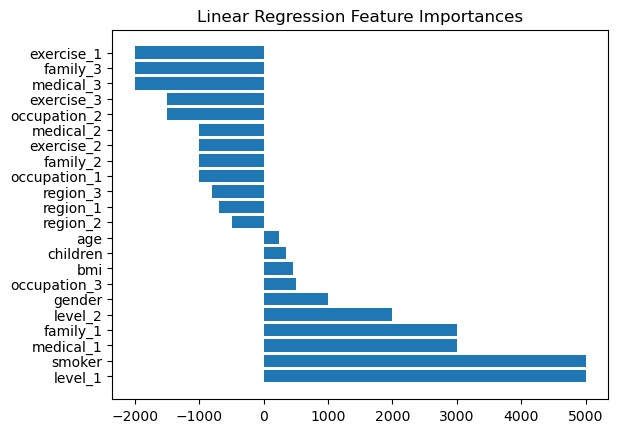

In [45]:
# Linear Regression 속성 중요도 시각화
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.title('Linear Regression Feature Importances')
plt.show()

In [46]:
# CatBoostRegressor 속성 중요도 확인
importance_df = pd.DataFrame({
        "Feature": train_input.columns,
        "Importance": cat.feature_importances_
    }).sort_values(by="Importance", ascending=False)
print(importance_df)

         Feature  Importance
4         smoker   30.678264
20       level_1   19.617707
11      family_1   13.809048
8      medical_1   13.794441
21       level_2    3.288897
10     medical_3    2.975399
13      family_3    2.860299
14    exercise_1    2.122056
18  occupation_2    1.467989
16    exercise_3    1.333031
19  occupation_3    1.243689
1         gender    1.224932
2            bmi    1.062377
9      medical_2    0.809465
12      family_2    0.790550
17  occupation_1    0.688221
15    exercise_2    0.610854
3       children    0.570239
0            age    0.383437
7       region_3    0.291238
5       region_1    0.257181
6       region_2    0.120686


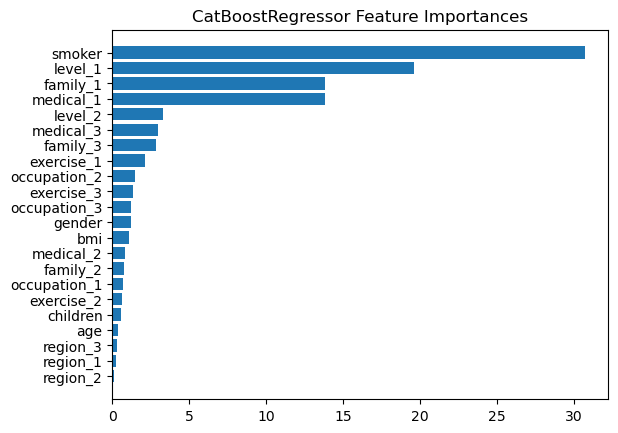

In [48]:
# CatBoostRegressor 속성 중요도 시각화
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('CatBoostRegressor Feature Importances')
plt.show()

In [49]:
# LGBMRegressor 속성 중요도 확인
importance_df = pd.DataFrame({
        "Feature": train_input.columns,
        "Importance": lgbm.feature_importances_
    }).sort_values(by="Importance", ascending=False)
print(importance_df)

         Feature  Importance
2            bmi         874
0            age         452
3       children         451
20       level_1         427
21       level_2         360
4         smoker         290
9      medical_2         208
8      medical_1         205
12      family_2         189
17  occupation_1         174
16    exercise_3         163
11      family_1         161
10     medical_3         154
18  occupation_2         115
13      family_3         113
7       region_3         103
14    exercise_1         100
15    exercise_2          98
6       region_2          71
19  occupation_3          69
1         gender          63
5       region_1          60


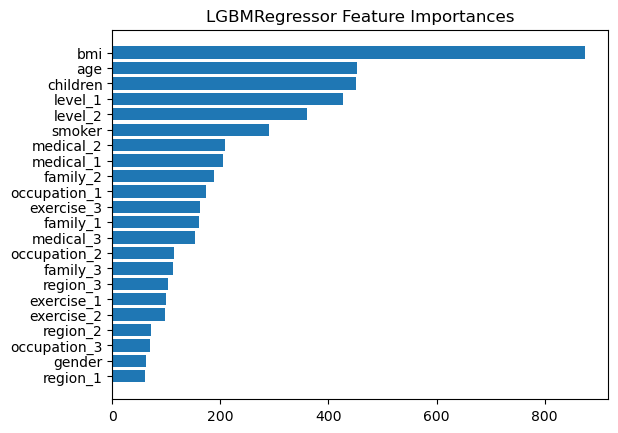

In [50]:
# LGBMRegressor 속성 중요도 시각화
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('LGBMRegressor Feature Importances')
plt.show()

In [51]:
# XGBRegressor 속성 중요도 확인
importance_df = pd.DataFrame({
        "Feature": train_input.columns,
        "Importance": xgb.feature_importances_
    }).sort_values(by="Importance", ascending=False)
print(importance_df)

         Feature  Importance
4         smoker    0.282573
11      family_1    0.166775
8      medical_1    0.126446
20       level_1    0.086216
13      family_3    0.074593
1         gender    0.066275
10     medical_3    0.040521
14    exercise_1    0.036302
18  occupation_2    0.027509
19  occupation_3    0.025417
21       level_2    0.018561
12      family_2    0.007292
16    exercise_3    0.007212
17  occupation_1    0.006591
5       region_1    0.005638
15    exercise_2    0.004373
9      medical_2    0.003886
6       region_2    0.003566
7       region_3    0.003474
2            bmi    0.002595
3       children    0.002305
0            age    0.001879


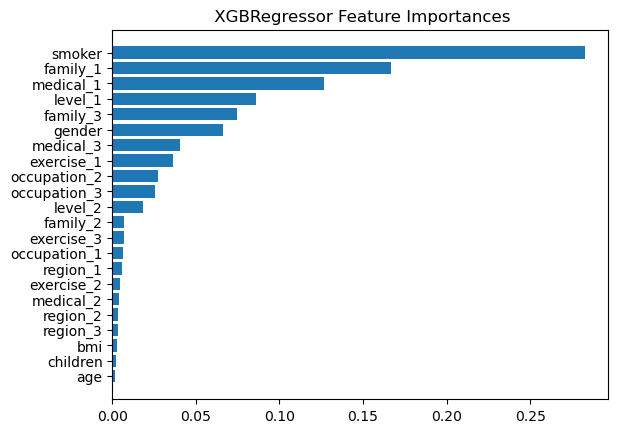

In [52]:
# XGBRegressor 속성 중요도 시각화
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title(' XGBRegressor Feature Importances')
plt.show()